In [4]:
!unzip /content/train.zip -d /content/Train

Archive:  /content/train.zip
   creating: /content/Train/target_4_December_release/
   creating: /content/Train/target_4_December_release/BG/
   creating: /content/Train/target_4_December_release/BG/raw-documents/
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10015.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10345.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10380.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10468.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10525.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10556.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10565.txt  
  inflating: /content/Train/target_4_December_release/BG/raw-documents/A6_CC_BG_10575.txt  
  inflating: /content/Train/target_4_December_rele

#Imports


In [2]:
!pip install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
import os
import torch
from transformers import XLMRobertaTokenizer
from torch.utils.data import Dataset

In [6]:
# Paths
DATA_DIR = "/content/Train"
LANGUAGES = ["BG", "EN", "HI", "PT", "RU"]

# Role Labels
MAIN_ROLES = {"Protagonist": 0, "Antagonist": 1, "Innocent": 2}
FINE_GRAINED_ROLES = {
    "Protagonist": ["Guardian", "Martyr", "Peacemaker", "Rebel", "Underdog", "Virtuous"],
    "Antagonist": [
        "Instigator", "Conspirator", "Tyrant", "Foreign Adversary", "Traitor",
        "Spy", "Saboteur", "Corrupt", "Incompetent", "Terrorist", "Deceiver", "Bigot"
    ],
    "Innocent": ["Forgotten", "Exploited", "Victim", "Scapegoat"]
}

# To Calculate the total number of unique fine-grained roles
all_fine_grained_roles = set()
for roles in FINE_GRAINED_ROLES.values():
    all_fine_grained_roles.update(roles)
num_fine_grained_roles = len(all_fine_grained_roles)
print(f"Total fine-grained roles: {num_fine_grained_roles}")

Total fine-grained roles: 22


#Data Preprocessing


In [7]:
# Load Tokenizer

from transformers import XLMRobertaTokenizerFast

TOKENIZER = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
SPECIAL_TOKENS = {
    "additional_special_tokens": ["<ent>", "</ent>"]
}
TOKENIZER.add_special_tokens(SPECIAL_TOKENS)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

2

In [8]:
from torch.utils.data import Dataset
import torch

class EntityDataset(Dataset):
    def __init__(self, annotations, tokenizer, num_fine_grained_roles):
        self.annotations = annotations
        self.tokenizer = tokenizer
        self.num_fine_grained_roles = num_fine_grained_roles

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        data = self.annotations[idx]
        text = data["text"]
        entity = data["entity"]
        start, end = data["start"], data["end"]
        main_role = data["main_role"]
        fine_grained_roles = data["fine_grained_roles"]

        # Extract window of 100 characters before and after entity
        start_idx = max(0, start - 100)
        end_idx = min(len(text), end + 100)
        context_text = text[start_idx:end_idx]

        # Adjust positions for context
        adj_start = start - start_idx
        adj_end = end - start_idx

        # Insert entity markers
        marked_text = context_text[:adj_start] + "<ent>" + entity + "</ent>" + context_text[adj_end:]


        # Tokenize with entity markers
        inputs = self.tokenizer(marked_text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)

        # Initialized attention weights
        attention_weights = torch.ones_like(input_ids, dtype=torch.float)

        ent_start_token = TOKENIZER.convert_tokens_to_ids("<ent>")
        ent_end_token = TOKENIZER.convert_tokens_to_ids("</ent>")

        start_pos = (input_ids == ent_start_token).nonzero(as_tuple=True)[0]
        end_pos = (input_ids == ent_end_token).nonzero(as_tuple=True)[0]

        if len(start_pos) > 0 and len(end_pos) > 0:
            s_idx = start_pos[0].item()
            e_idx = end_pos[0].item()
            attention_weights[s_idx:e_idx + 1] = 2.0  # Increased attention weights for entity


        # Encode main role (single label classification)
        main_role_label = torch.tensor(MAIN_ROLES[main_role], dtype=torch.long)

        # Encode fine-grained roles (multi-label classification)
        role_list = FINE_GRAINED_ROLES[main_role]
        label_vector = [1 if role in fine_grained_roles else 0 for role in role_list]
        label_vector += [0] * (self.num_fine_grained_roles - len(label_vector))
        fine_grained_labels = torch.tensor(label_vector, dtype=torch.float)

        return input_ids, attention_mask, attention_weights, main_role_label, fine_grained_labels


In [9]:
# Loaded Data
def load_data():
    annotations = []
    lang_counts = {lang: 0 for lang in LANGUAGES}
    lang_annotations = {lang: [] for lang in LANGUAGES}

    # Calculated the total number of unique fine-grained roles
    all_fine_grained_roles = set()
    for roles in FINE_GRAINED_ROLES.values():
        all_fine_grained_roles.update(roles)
    num_fine_grained_roles = len(all_fine_grained_roles)
    print(f"Total fine-grained roles: {num_fine_grained_roles}")

    for lang in LANGUAGES:
        lang_path = os.path.join(DATA_DIR, "target_4_December_release", lang)
        annotation_file = os.path.join(lang_path, "subtask-1-annotations.txt")

        if not os.path.exists(annotation_file):
            print(f"Warning: No annotations found for {lang}")
            continue

        with open(annotation_file, "r", encoding="utf-8") as file:
            for line in file:
                parts = line.strip().split("\t")
                article_id, entity, start, end, main_role, *fine_grained_roles = parts
                start, end = int(start), int(end)

                text_file = os.path.join(lang_path, "raw-documents", article_id)
                if not os.path.exists(text_file):
                    print(f"Warning: Missing text file {article_id} in {lang}")
                    continue

                with open(text_file, "r", encoding="utf-8") as f:
                    text = f.read()

                annotation = {
                    "text": text,
                    "entity": entity,
                    "start": start,
                    "end": end,
                    "main_role": main_role,
                    "fine_grained_roles": fine_grained_roles
                }

                annotations.append(annotation)
                lang_annotations[lang].append(annotation)
                lang_counts[lang] += 1

    return annotations, lang_counts, lang_annotations, num_fine_grained_roles

In [10]:
# Execution Code
if __name__ == "__main__":
    print("Loading data...")
    annotations, lang_counts, lang_annotations, num_fine_grained_roles = load_data()

    # Initialized Dataset with all annotations
    dataset = EntityDataset(annotations, TOKENIZER, num_fine_grained_roles)

    print("\n### Annotations per Language ###")
    for lang, count in lang_counts.items():
        print(f"{lang}: {count} annotations")

    print("\n### Sample Preprocessed Output per Language ###")
    for lang, lang_anns in lang_annotations.items():
        print(f"\nLanguage: {lang}")
        lang_dataset = EntityDataset(lang_anns, TOKENIZER, num_fine_grained_roles)

        # Displayed 4 samples per language
        for i in range(min(4, len(lang_dataset))):
            input_ids, attention_mask, attention_weights, main_role_label, fine_grained_labels = lang_dataset[i]

            print(f"\nExample {i+1}:")
            print("Entity Name:", lang_anns[i]['entity'])
            print("Decoded Text:", TOKENIZER.decode(input_ids[:100].tolist()))
            print("Tokenized Input IDs:", input_ids[:100].tolist())
            print("Attention Mask:", attention_mask[:100].tolist())
            print("Attention Weights (first 100):", attention_weights[:100].tolist())
            print("Main Role Label:", main_role_label.item())
            print("Fine-Grained Labels:", fine_grained_labels.numpy().tolist())


Loading data...
Total fine-grained roles: 22

### Annotations per Language ###
BG: 627 annotations
EN: 686 annotations
HI: 2331 annotations
PT: 1251 annotations
RU: 367 annotations

### Sample Preprocessed Output per Language ###

Language: BG

Example 1:
Entity Name: Запад
Decoded Text: <s> ъцете на властите в Киев „се провали с гръм и трясък“ и скоро от Украйна ... Опитът на колективния<ent> Запад</ent> д да „обезкърви Русия“ с ръцете на властите в Киев „се провали с гръм и трясък“ и скоро от Украйна н</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Tokenized Input IDs: [0, 6, 9430, 2188, 226, 29, 12747, 226, 49, 94511, 137, 2687, 591, 7533, 135, 10099, 54293, 35, 25977, 245, 131732, 155, 35, 18777, 183, 159814, 153, 1089, 22617, 1669, 29, 47829, 2097, 250002, 32275, 250003, 4737, 69, 137, 197, 35359, 53335, 2827, 40053, 155, 135, 128601, 29, 12747, 226, 49, 94511, 137, 2687, 591

# Training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Constants
MODEL_NAME = "xlm-roberta-base"
BATCH_SIZE = 4
epochs = 15
lr = 1e-5
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
EARLY_STOPPING_PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loaded Tokenizer
TOKENIZER = XLMRobertaTokenizerFast.from_pretrained(MODEL_NAME)
torch.cuda.empty_cache()

#To get Hierarchical Mapping
MAIN_ROLES = {"Protagonist": 0, "Antagonist": 1, "Innocent": 2}
FINE_GRAINED_ROLES = {
    "Protagonist": ["Guardian", "Martyr", "Peacemaker", "Rebel", "Underdog", "Virtuous"],
    "Antagonist": [
        "Instigator", "Conspirator", "Tyrant", "Foreign Adversary", "Traitor",
        "Spy", "Saboteur", "Corrupt", "Incompetent", "Terrorist", "Deceiver", "Bigot"
    ],
    "Innocent": ["Forgotten", "Exploited", "Victim", "Scapegoat"]
}
# Created mapping from main role ID to fine role indices
fine_role_list = sum(FINE_GRAINED_ROLES.values(), [])
fine_role_indices_by_main_id = {
    MAIN_ROLES[main_role]: [
        fine_role_list.index(role) for role in FINE_GRAINED_ROLES[main_role]
    ]
    for main_role in MAIN_ROLES
}

In [12]:
def compute_fine_label_weights(annotations, num_fine_classes):
    label_counts = torch.zeros(num_fine_classes)
    for annotation in annotations:
        fine_labels = annotation["fine_grained_roles"]
        # Encoded fine-grained roles
        label_counts += torch.tensor([1 if role in fine_labels else 0 for role in fine_role_list], dtype=torch.float32)

    label_freqs = label_counts / label_counts.sum()
    weights = 1.0 / (label_freqs + 1e-6)
    weights = weights / weights.mean()
    return weights

In [13]:
class XLMRClassifier(nn.Module):
    def __init__(self, num_main_roles, fine_roles_dict, freeze_layers=True):
        super(XLMRClassifier, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained("xlm-roberta-base")

        if freeze_layers:
            for i in range(9):  # freezed first 9 layers of base model
                for param in self.xlm_roberta.encoder.layer[i].parameters():
                    param.requires_grad = False

        hidden_size = 768  # for base model parrameters
        self.dropout = nn.Dropout(0.05)
        self.projection = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.main_role_classifier = nn.Linear(hidden_size, len(MAIN_ROLES)) # single Classfication Head

        # 3 classification HEads
        self.fine_classifiers = nn.ModuleDict()
        for role, roles_list in fine_roles_dict.items():
            self.fine_classifiers[str(MAIN_ROLES[role])] = nn.Linear(hidden_size, len(roles_list))

    def forward(self, input_ids, attention_mask, attention_weights=None):
        if attention_weights is not None:
            attention_mask = attention_mask.float() * attention_weights

        outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0]
        x = self.dropout(cls_embedding)
        x = self.projection(x)
        x = self.relu(x)
        x = self.dropout(x)
        main_logits = self.main_role_classifier(x)

        return main_logits, x


In [16]:
def train_model(model, train_loader, val_loader, epochs, lr, annotations):
    model.to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2, verbose=True)

    criterion_main = nn.CrossEntropyLoss()  # Loss function for Main role
    fine_label_weights = compute_fine_label_weights(annotations, len(fine_role_list)).to(DEVICE)
    criterion_fine = nn.BCEWithLogitsLoss(weight=fine_label_weights)  # Loss function for Fine-grained roles

    best_val_loss = float("inf")
    best_threshold = 0.50
    patience_counter = 0

    # Total number of fine-grained roles across all main roles
    total_fine_roles = sum(len(fine_role_indices_by_main_id[i]) for i in range(len(MAIN_ROLES)))

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        all_preds_main, all_labels_main = [], []
        all_preds_fine, all_labels_fine = [], []

        for input_ids, attn_mask, attn_weights, main_role_label, fine_labels in train_loader:
            input_ids, attn_mask, attn_weights = input_ids.to(DEVICE), attn_mask.to(DEVICE), attn_weights.to(DEVICE)
            main_role_label, fine_labels = main_role_label.to(DEVICE), fine_labels.to(DEVICE).float()

            optimizer.zero_grad()
            main_logits, features = model(input_ids, attn_mask, attn_weights)

            loss_main = criterion_main(main_logits, main_role_label)

            # Initialized fine_logits with zeros of size [batch_size, total_fine_roles]
            fine_logits = torch.zeros((input_ids.size(0), total_fine_roles)).to(DEVICE)

            for i, main_class in enumerate(main_role_label):
                main_class_str = str(main_class.item())
                fine_classifier = model.fine_classifiers[main_class_str]
                fine_out = fine_classifier(features[i].unsqueeze(0))

                #Allowed only that indices for fine-grained roles based on main class
                allowed_indices = fine_role_indices_by_main_id[main_class.item()]

                # Assigned fine-grained logits to the corresponding indices
                fine_logits[i, allowed_indices] = fine_out.squeeze(0)

            loss_fine = criterion_fine(fine_logits, fine_labels)
            loss = loss_main + loss_fine

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_train_loss += loss.item()
            main_preds = torch.argmax(main_logits, dim=1)
            fine_preds = (torch.sigmoid(fine_logits) > best_threshold).int()

            all_preds_main.extend(main_preds.cpu().numpy())
            all_labels_main.extend(main_role_label.cpu().numpy())
            all_preds_fine.extend(fine_preds.cpu().numpy())
            all_labels_fine.extend(fine_labels.cpu().numpy())

        train_main_acc = accuracy_score(all_labels_main, all_preds_main)
        train_fine_f1 = f1_score(all_labels_fine, all_preds_fine, average="micro")


        # Validation begins Here
        model.eval()
        val_loss = 0
        val_preds_main, val_labels_main = [], []
        val_probs_fine, val_labels_fine = [], []

        with torch.no_grad():
            for input_ids, attn_mask, attn_weights, main_role_label, fine_labels in val_loader:
                input_ids, attn_mask, attn_weights = input_ids.to(DEVICE), attn_mask.to(DEVICE), attn_weights.to(DEVICE)
                main_role_label, fine_labels = main_role_label.to(DEVICE), fine_labels.to(DEVICE).float()

                main_logits, features = model(input_ids, attn_mask, attn_weights)

                loss_main = criterion_main(main_logits, main_role_label)
                main_preds = torch.argmax(main_logits, dim=1)

                # Initialized fine_logits with zeros of size [batch_size, total_fine_roles]
                fine_logits = torch.zeros((input_ids.size(0), total_fine_roles)).to(DEVICE)

                for i, main_class in enumerate(main_preds):
                    main_class_str = str(main_class.item())
                    fine_classifier = model.fine_classifiers[main_class_str]
                    fine_out = fine_classifier(features[i].unsqueeze(0))

                    # Allowed indices for fine-grained roles based on main class
                    allowed_indices = fine_role_indices_by_main_id[main_class.item()]

                    # Assigned fine-grained logits to the corresponding indices
                    fine_logits[i, allowed_indices] = fine_out.squeeze(0)

                loss_fine = criterion_fine(fine_logits, fine_labels)
                loss = loss_main + loss_fine
                val_loss += loss.item()

                val_preds_main.extend(main_preds.cpu().numpy())
                val_labels_main.extend(main_role_label.cpu().numpy())
                val_probs_fine.extend(torch.sigmoid(fine_logits).cpu().numpy())
                val_labels_fine.extend(fine_labels.cpu().numpy())

        val_main_acc = accuracy_score(val_labels_main, val_preds_main)
        val_probs_fine_np = np.array(val_probs_fine)
        val_labels_fine_np = np.array(val_labels_fine)

        val_preds_fine_np = (val_probs_fine_np > best_threshold).astype(int)

        val_fine_f1 = f1_score(val_labels_fine_np, val_preds_fine_np, average="micro")

        print(f"[{epoch+1}/{epochs}] Train Loss: {total_train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Main Acc -> Train: {train_main_acc:.4f}, Val: {val_main_acc:.4f}")
        print(f"Fine F1  -> Train: {train_fine_f1:.4f}, Val: {val_fine_f1:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_model.pth"))
    return model


#Saved the final model
def save_model(model, path="trained_model.pt"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


In [ ]:
if __name__ == "__main__":
    print("Loading data...")

    # Loaded annotations and determined the number of fine roles.
    annotations, lang_counts, lang_annotations, num_fine_grained_roles = load_data()

    # Used predefined role dictionaries
    fine_role_list = sum(FINE_GRAINED_ROLES.values(), [])  # flattened list of all 22 fine roles
    main_role_list = list(MAIN_ROLES.keys())

    # Mapping from main role ID to the indices of their fine-grained roles
    fine_role_indices_by_main_id = {
        MAIN_ROLES[main_role]: [
            fine_role_list.index(role) for role in FINE_GRAINED_ROLES[main_role]
        ]
        for main_role in MAIN_ROLES
    }

    # Created the dataset using total number of fine roles
    dataset = EntityDataset(annotations, TOKENIZER, num_fine_grained_roles)

    # Split
    train_idx, val_idx = train_test_split(
        range(len(dataset)),
        test_size=0.2,
        stratify=[ann["main_role"] for ann in annotations]
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Initialized model
    model = XLMRClassifier(
        num_main_roles=len(MAIN_ROLES),
        fine_roles_dict=FINE_GRAINED_ROLES,
        freeze_layers=True
    )

    # Train model
    trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    annotations=annotations
)


    # Saved the trained model
    save_model(trained_model)


Loading data...
Total fine-grained roles: 22


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

[1/15] Train Loss: 2205.9510 | Val Loss: 496.6903
Main Acc -> Train: 0.5101, Val: 0.6268
Fine F1 -> Train: 0.0000, Val: 0.0000
Model saved!
[2/15] Train Loss: 1972.5541 | Val Loss: 461.6332
Main Acc -> Train: 0.6220, Val: 0.6923
Fine F1 -> Train: 0.0556, Val: 0.1413
Model saved!
[3/15] Train Loss: 1815.4441 | Val Loss: 436.3233
Main Acc -> Train: 0.6976, Val: 0.7569
Fine F1 -> Train: 0.1227, Val: 0.1778
Model saved!
[4/15] Train Loss: 1736.6072 | Val Loss: 427.9001
Main Acc -> Train: 0.7410, Val: 0.7578
Fine F1 -> Train: 0.1541, Val: 0.1846
Model saved!
[5/15] Train Loss: 1676.8341 | Val Loss: 424.6447
Main Acc -> Train: 0.7688, Val: 0.7645
Fine F1 -> Train: 0.1723, Val: 0.1712
Model saved!
[6/15] Train Loss: 1608.6002 | Val Loss: 429.9959
Main Acc -> Train: 0.7973, Val: 0.7778
Fine F1 -> Train: 0.1891, Val: 0.2749
[7/15] Train Loss: 1564.4363 | Val Loss: 418.9879
Main Acc -> Train: 0.8068, Val: 0.7806
Fine F1 -> Train: 0.2111, Val: 0.2420
Model saved!
[8/15] Train Loss: 1524.3542 | Va

**Best Results**:

Best Validation Accuracy: 79.01%

Best Fine-Grained Validation F1 Score: 32.97%

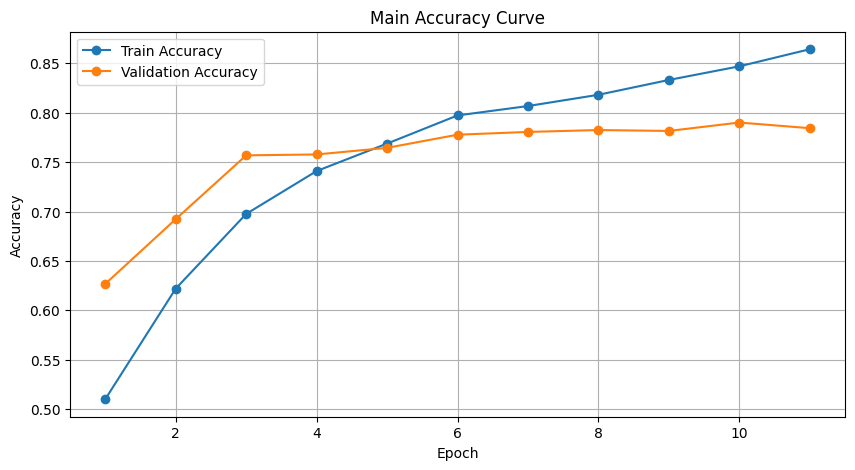

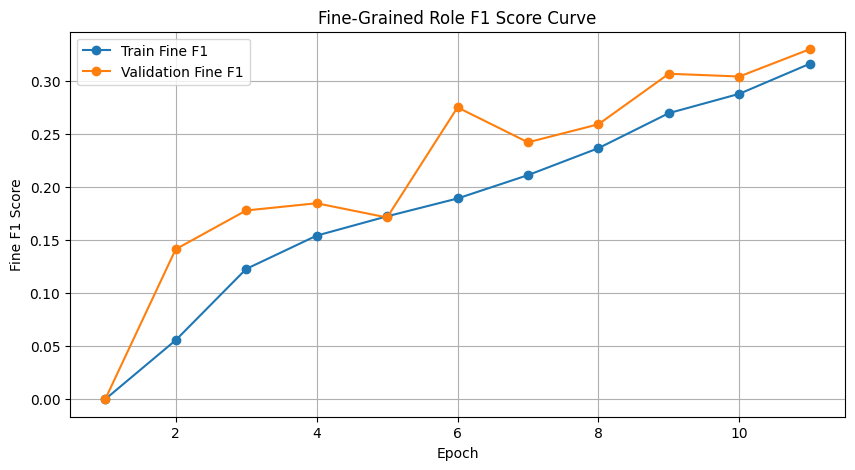

In [3]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 11 + 1))
train_acc = [0.5101, 0.6220, 0.6976, 0.7410, 0.7688, 0.7973, 0.8068, 0.8182, 0.8332, 0.8470, 0.8643]
val_acc = [0.6268, 0.6923, 0.7569, 0.7578, 0.7645, 0.7778, 0.7806, 0.7825, 0.7816, 0.7901, 0.7844]
train_f1 = [0.0000, 0.0556, 0.1227, 0.1541, 0.1723, 0.1891, 0.2111, 0.2365, 0.2695, 0.2877, 0.3160]
val_f1 = [0.0000, 0.1413, 0.1778, 0.1846, 0.1712, 0.2749, 0.2420, 0.2590, 0.3066, 0.3040, 0.3297]


# Ploted Main Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Main Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# Ploted Fine-Grained F1 Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1, label='Train Fine F1', marker='o')
plt.plot(epochs, val_f1, label='Validation Fine F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Fine F1 Score')
plt.title('Fine-Grained Role F1 Score Curve')
plt.legend()
plt.grid(True)
plt.show()
